#### IMPORTS, SETTINGS, DATA PREPARATION #####

In [ ]:
import sys, os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

# Load and preprocess data
df = pd.read_csv("data/cheating_experiment_dataset.csv")

In [112]:
# Data preparation
df['cheating_behavior'] = df['cheating_behavior'].fillna(0)
df['integrity_group'] = pd.cut(
    df['cheating_behavior'],
    bins=[-0.001, 0.001, 0.999, 1.001],
    labels=['non_cheaters', 'partial_cheaters', 'full_cheaters']
)

df['condition'] = df['concept'].apply(
    lambda x: 'control' if pd.isna(x) else ('intervention' if x == 'intervention' else x)
)

# Order conditions
concept_order = [
    'control', 'intervention',
    'autonomy', 'competence', 'relatedness', 'self_concept',
    'cognitive_inconsistency', 'dissonance_arousal', 'dissonance_reduction',
    'descriptive_norms', 'injunctive_norms', 'social_sanctions', 
    'reference_group_identification', 'performance_accomplishments',
    'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

concept_display_names = {
    'control': 'Control',
    'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)',
    'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)',
    'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Reference Group Identification (SNT)',
    'performance_accomplishments': 'Performance Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

concept_display_names= {
    'control': 'Control',
    'intervention': 'Intervention',
    'autonomy': 'Autonomy (SDT)',
    'competence': 'Competence (SDT)',
    'relatedness': 'Relatedness (SDT)',
    'self_concept': 'Self Concept (SDT)',
    'cognitive_inconsistency': 'Cognitive Inconsistency (CDT)',
    'dissonance_arousal': 'Dissonance Arousal (CDT)',
    'dissonance_reduction': 'Dissonance Reduction (CDT)',
    'descriptive_norms': 'Descriptive Norms (SNT)',
    'injunctive_norms': 'Injunctive Norms (SNT)',
    'social_sanctions': 'Social Sanctions (SNT)',
    'reference_group_identification': 'Ref. Group Identity (SNT)',
    'performance_accomplishments': 'Perf. Accomplishments (SET)',
    'vicarious_experience': 'Vicarious Experience (SET)',
    'verbal_persuasion': 'Verbal Persuasion (SET)',
    'emotional_arousal': 'Emotional Arousal (SET)'
}

# Define mechanisms
mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms', 
    'social_sanctions', 'reference_group_identification', 
    'performance_accomplishments', 'vicarious_experience', 
    'verbal_persuasion', 'emotional_arousal', 'perceived_ability'
]

mechanism_display_names = {
    'autonomy_need_satisfaction': 'Autonomy Satisfaction',
    'autonomy_need_frustration': 'Autonomy Frustration',
    'competence_need_satisfaction': 'Competence Satisfaction',
    'competence_need_frustration': 'Competence Frustration',
    'relatedness_need_satisfaction': 'Relatedness Satisfaction',
    'relatedness_need_frustration': 'Relatedness Frustration',
    'cognitive_discomfort': 'Cognitive Discomfort',
    'moral_disengagement': 'Moral Disengagement',
    'injunctive_norms': 'Percv. Injunctive Norms',
    'descriptive_norms': 'Percv. Descriptive Norms',
    'social_sanctions': 'Percv. Social Sanctions',
    'reference_group_identification': 'Percv. Ref. Group Identity',
    'performance_accomplishments': 'Percv. Perf. Accomplishments',
    'vicarious_experience': 'Percv. Vicarious Experience',
    'verbal_persuasion': 'Percv. Verbal Persuasion',
    'emotional_arousal': 'Percv. Emotional Arousal',
    'perceived_ability': 'Percv. Ability'
}

# Define mechanism-to-theory mapping
mechanism_theory = {
    'autonomy_need_satisfaction': 'SDT',
    'autonomy_need_frustration': 'SDT',
    'competence_need_satisfaction': 'SDT',
    'competence_need_frustration': 'SDT',
    'relatedness_need_satisfaction': 'SDT',
    'relatedness_need_frustration': 'SDT',
    'cognitive_discomfort': 'CET',
    'moral_disengagement': 'CET',
    'injunctive_norms': 'SNT',
    'descriptive_norms': 'SNT',
    'social_sanctions': 'SNT',
    'reference_group_identification': 'SNT',
    'performance_accomplishments': 'SET',
    'vicarious_experience': 'SET',
    'verbal_persuasion': 'SET',
    'emotional_arousal': 'SET'
}

In [113]:
# Bootstrap function
def compute_integrity_distribution(data):
    result = data.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
    totals = result.groupby('condition')['n'].sum().reset_index(name='total')
    result = result.merge(totals, on='condition')
    result['percent'] = (result['n'] / result['total']) * 100
    return result[['condition', 'integrity_group', 'percent']]

# Bootstrap sampling
n_bootstrap = 1000
boot_results = []
for _ in range(n_bootstrap):
    sample = df.sample(n=len(df), replace=True)
    boot_results.append(compute_integrity_distribution(sample))

boot_df = pd.concat(boot_results, ignore_index=True)

# Calculate confidence intervals
ci_df = boot_df.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()

#### RQ1: 
#### **Do concept-based interventions reduce cheating behavior?** - ONLY SIGNIFICANT FOR FULL CHEATERS (~40% reduced relative to control) 
#### **Do effects vary by concepts?** - NO; all concepts reduce cheating behavior consistently

In [114]:
# =====================================================================
# Data preparation for RQ1 plots
# =====================================================================

# Combine intervention concepts
intervention_combined = df[df['condition'] != 'control'].copy()
intervention_combined['condition'] = 'intervention'
df_combined = pd.concat([df, intervention_combined], ignore_index=True)


boot_results_combined = []
for _ in range(n_bootstrap):
    sample = df_combined.sample(n=len(df_combined), replace=True)
    boot_results_combined.append(compute_integrity_distribution(sample))

boot_df_combined = pd.concat(boot_results_combined, ignore_index=True)
ci_df_combined = boot_df_combined.groupby(['condition', 'integrity_group'])['percent'].agg([
    ('mean', 'mean'),
    ('lower', lambda x: np.percentile(x, 2.5)),
    ('upper', lambda x: np.percentile(x, 97.5))
]).reset_index()


formatted_labels = [f'$\\bf{{{concept_display_names[c]}}}$' if c in ['control', 'intervention'] 
                    else concept_display_names[c] for c in concept_order]

sample_sizes = df_combined.groupby(['condition', 'integrity_group']).size().reset_index(name='n')
ci_df_combined = ci_df_combined.merge(sample_sizes, on=['condition', 'integrity_group'], how='left')


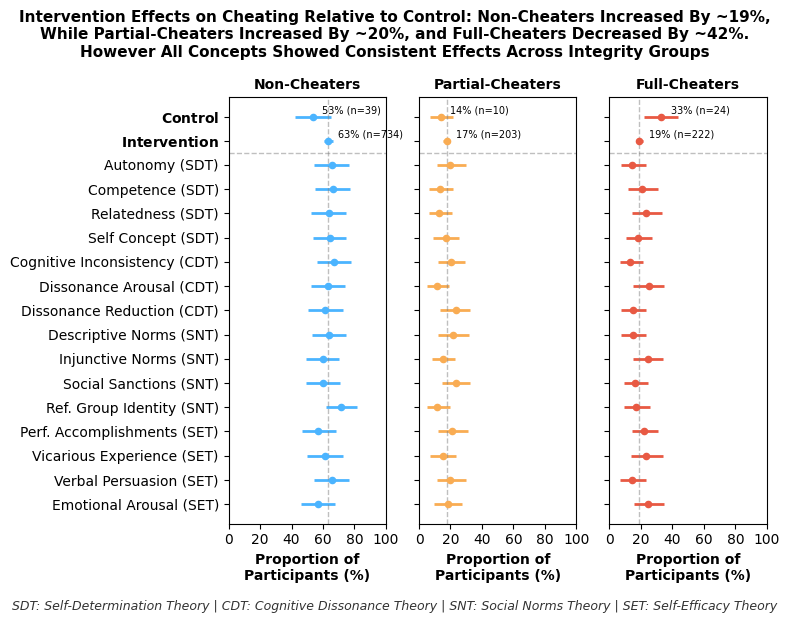


=== Cheating proportions used in plots (mean ± 95% CI) ===

Integrity group: NON_CHEATERS
                     Condition Mean (%) Lower CI Upper CI
                       control    53.50    42.46    65.22
                  intervention    63.40    60.53    66.08
                      autonomy    65.57    54.32    76.47
                    competence    66.12    54.92    77.42
                   relatedness    64.11    52.56    74.63
                  self_concept    64.35    53.61    74.65
       cognitive_inconsistency    66.67    56.32    77.47
            dissonance_arousal    63.48    52.63    74.03
          dissonance_reduction    61.53    50.70    72.47
             descriptive_norms    63.84    53.01    74.33
              injunctive_norms    60.19    49.41    70.37
              social_sanctions    60.12    49.29    70.67
reference_group_identification    71.61    61.64    81.71
   performance_accomplishments    56.90    46.37    68.42
          vicarious_experience    61.43

In [115]:
# =============================================================================
# RQ1 Plots: Integrity Distribution by Concept and Integrity Group
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(8, 6), sharey=True)
integrity_groups = ['non_cheaters', 'partial_cheaters', 'full_cheaters']
colors = ["#4bb4ff", "#f9ac53", "#e85943"]
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']

for idx, (ax, group, color, title) in enumerate(zip(axes, integrity_groups, colors, titles)):
    data = ci_df_combined[ci_df_combined['integrity_group'] == group]
    data = data.set_index('condition').reindex(concept_order).reset_index()
    
    y = np.arange(len(concept_order))
    ax.scatter(data['mean'], y, color=color, s=20, zorder=3)
    ax.hlines(y, data['lower'], data['upper'], color=color, linewidth=2, zorder=2)
    for _, row in data.iterrows():
        if row['condition'] in ['control', 'intervention']:
            ax.text(
                row['mean'] + 6, 
                y[list(data['condition']).index(row['condition'])] - 0.25,
                f"{row['mean']:.0f}% (n={row['n']})",  
                va='center', ha='left', fontsize=7, color='black'
            )
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_yticks(y)
    ax.set_yticklabels(formatted_labels, fontsize=10)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('Proportion of\nParticipants (%)', fontsize=10, fontweight='bold')
    # ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.axhline(y=1.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=data.loc[data['condition'] == 'intervention', 'mean'].values[0], 
           color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.invert_yaxis()
    
fig.suptitle(
    'Intervention Effects on Cheating Relative to Control: Non-Cheaters Increased By ~19%,\n'
    'While Partial-Cheaters Increased By ~20%, and Full-Cheaters Decreased By ~42%.\n'
    'However All Concepts Showed Consistent Effects Across Integrity Groups',
    fontsize=11, fontweight='bold', y=0.98
)


fig.text(0.5, -0.02,
            "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
            "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
            ha='center', fontsize=9, style='italic', color='black', alpha=0.8)

plt.tight_layout()
# plt.savefig('integrity_distribution_by_concept.png', dpi=300, bbox_inches='tight')
plt.show()


# === (1) Print plotted values in concept_order ===
print("\n=== Cheating proportions used in plots (mean ± 95% CI) ===")

for group in integrity_groups:
    print(f"\nIntegrity group: {group.upper()}")
    subset = (
        ci_df_combined[ci_df_combined['integrity_group'] == group]
        .set_index('condition')
        .reindex(concept_order)
        .reset_index()
    )
    subset_print = subset[['condition', 'mean', 'lower', 'upper']].copy()
    subset_print.columns = ['Condition', 'Mean (%)', 'Lower CI', 'Upper CI']
    print(subset_print.to_string(index=False, formatters={
        'Mean (%)': '{:.2f}'.format,
        'Lower CI': '{:.2f}'.format,
        'Upper CI': '{:.2f}'.format
    }))

# === (2) Chi-square significance tests (Control vs Intervention) ===
from scipy.stats import chi2_contingency

print("\n=== Chi-square tests: Control vs Intervention for each integrity group ===")

for group in integrity_groups:
    # Count participants in this group by condition
    control_count = len(df[(df['condition'] == 'control') & (df['integrity_group'] == group)])
    intervention_count = len(df[(df['condition'] != 'control') & (df['integrity_group'] == group)])
    total_control = len(df[df['condition'] == 'control'])
    total_intervention = len(df[df['condition'] != 'control'])
    
    # 2x2 contingency: cheating group vs condition
    contingency = np.array([
        [control_count, total_control - control_count],
        [intervention_count, total_intervention - intervention_count]
    ])
    
    chi2, p, dof, exp = chi2_contingency(contingency)
    print(f"{group:>20s}: χ²={chi2:.3f}, p={p:.4f}")


#### RQ2a:
#### **Do concept-based interventions improve performance?** - NOT SIGNIFICANTLY; but slight improvement for non-cheaters
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT

In [58]:
# =====================================================================
# Data preparation for RQ2 plots
# =====================================================================

df_tmp = df_combined.copy()
df_tmp['integrity_group'] = 'all'
df_all = pd.concat([df_combined, df_tmp], ignore_index=True)
df_all['integrity_group'] = pd.Categorical(
    df_all['integrity_group'], 
    categories=['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all'],
    ordered=True
)

# Bootstrap function for mean and CI
def bootstrap_mean_ci(data, metric, n_boot=1000):
    results = []
    for condition in ['control', 'intervention']:
        for integrity_group in ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']:
            subset = data[(data['condition'] == condition) & 
                         (data['integrity_group'] == integrity_group)][metric].dropna()
            if len(subset) > 0:
                boot_means = [subset.sample(n=len(subset), replace=True).mean() 
                             for _ in range(n_boot)]
                results.append({
                    'condition': condition,
                    'integrity_group': integrity_group,
                    'mean': np.mean(boot_means),
                    'lower': np.percentile(boot_means, 2.5),
                    'upper': np.percentile(boot_means, 97.5)
                })
    return pd.DataFrame(results)

# Calculate bootstrap CIs for performance and experience
perf_ci = bootstrap_mean_ci(df_all, 'performance')
exp_ci = bootstrap_mean_ci(df_all, 'experience')

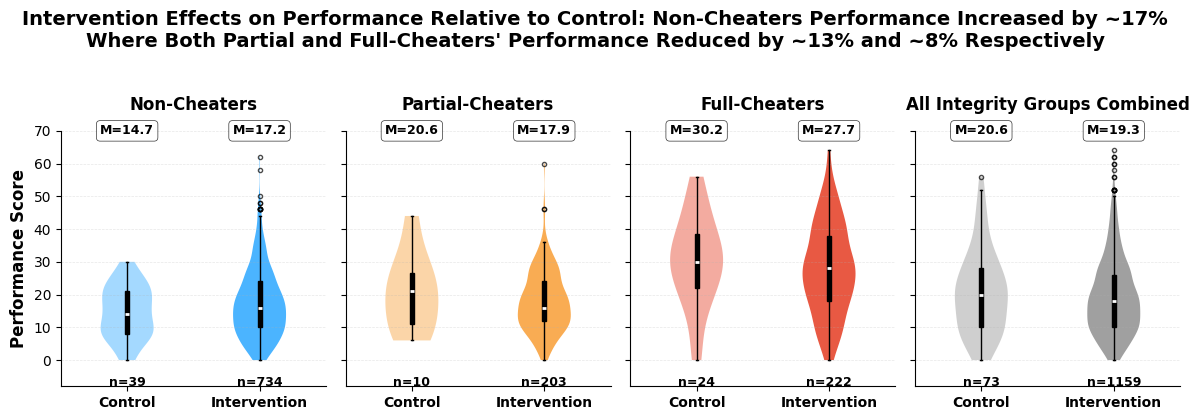


=== Performance Summary by Integrity Group and Condition ===
                                  N  Mean Median    SD
Integrity Group  Condition                            
non_cheaters     control         39 14.67  14.00  7.91
                 intervention   734 17.19  16.00 10.37
partial_cheaters control         10 20.60  21.00 11.85
                 intervention   203 17.94  16.00  9.18
full_cheaters    control         24 30.25  30.00 13.85
                 intervention   222 27.73  28.00 13.73
all              control         73 20.60  20.00 12.73
                 intervention  1159 19.34  18.00 11.64

=== Performance Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=1.909, p=0.0626
  Mann-Whitney U : U=15881.500, p=0.2476
  Cohen's d      : 0.274

PARTIAL_CHEATERS
  Welch t-test   : t=-0.699, p=0.5011
  Mann-Whitney U : U=897.000, p=0.5358
  Cohen's d      : -0.251

FULL_CHEATERS
  Welch t-test   : t=-0.848, p=0.4038
  Mann-Whitney U : U=2329

In [80]:
# =============================================================================
# RQ2 plots: Performance by Integrity Group and Condition
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
integrity_groups_all = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters', 'All Integrity Groups Combined']

integrity_colors = {
    'non_cheaters': '#4bb4ff', 
    'partial_cheaters': '#f9ac53',
    'full_cheaters': '#e85943',
    'all': '#a0a0a0'
}

condition_colors = {
    'control': '#d3d3d3', 
    'intervention': '#4bb4ff'
}

for idx, (ax, group, title) in enumerate(zip(axes, integrity_groups_all, titles)):
    if group == 'all':
        plot_data = df_combined 
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]
    
    control_data = plot_data[plot_data['condition']=='control']['performance'].dropna()
    intervention_data = plot_data[plot_data['condition']=='intervention']['performance'].dropna()
    
    # Violin plot
    parts = ax.violinplot([control_data, intervention_data], positions=[0, 1], widths=0.4,
                          showmeans=False, showmedians=False, showextrema=False)
    
    # Box plot inside each violin
    ax.boxplot([control_data, intervention_data], positions=[0, 1], widths=0.03,
               patch_artist=True,
               boxprops=dict(facecolor='black', color='black'),
               medianprops=dict(color='white', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1),
               capprops=dict(color='black', linewidth=1),
               showfliers=True,
               flierprops=dict(marker='o', markersize=3, 
                           markeredgecolor='black', alpha=0.7))
    
    # Color violins
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(integrity_colors[group])
        pc.set_alpha(0.5 if i == 0 else 1.0) 
        # pc.set_edgecolor('black')
        pc.set_linewidth(1)
    
    # Annotate n and mean
    for pos, condition_data in enumerate([control_data, intervention_data]):
        ax.text(pos, -5, f'n={len(condition_data)}', ha='center', va='top', fontsize=9, fontweight='bold')
        ax.text(pos, 68, f'M={condition_data.mean():.1f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.8))
    
    # Styling
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    ax.set_xticks([0, 1]); ax.set_xticklabels(['Control', 'Intervention'], fontsize=10, fontweight='bold')
    ax.set_ylim(-8, 70)
    if idx==0: ax.set_ylabel('Performance Score', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

fig.suptitle(
    "Intervention Effects on Performance Relative to Control: Non-Cheaters Performance Increased by ~17%\n"
    "Where Both Partial and Full-Cheaters' Performance Reduced by ~13% and ~8% Respectively",
    fontsize=14, fontweight='bold', y=0.93
)

plt.tight_layout(rect=[0, 0.1, 1, 0.90])
plt.show()


# =============================================================================
# Print statistics and significance tests
# =============================================================================

# === (1) Performance Summary by Integrity Group and Condition ===

print("\n=== Performance Summary by Integrity Group and Condition ===")
summary_rows = []
for group in integrity_groups_all:
    if group == 'all':
        plot_data = df_combined 
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

    for condition in ['control', 'intervention']:
        condition_data = plot_data[plot_data['condition'] == condition]['performance'].dropna()
        n = len(condition_data)
        mean = condition_data.mean()
        median = condition_data.median()
        std = condition_data.std()
        summary_rows.append({
            'Integrity Group': group,
            'Condition': condition,
            'N': n,
            'Mean': mean,
            'Median': median,
            'SD': std
        })

# Convert to DataFrame for clean display and sorting
import pandas as pd
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index(['Integrity Group', 'Condition'])
print(summary_df.to_string(formatters={
    'Mean': '{:.2f}'.format,
    'Median': '{:.2f}'.format,
    'SD': '{:.2f}'.format
}))


# === (2) Performance Comparison: Control vs Intervention (Welch t-test) ===

from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

print("\n=== Performance Comparison: Control vs Intervention (Welch t-test) ===")

for group in integrity_groups_all:
    if group == 'all':
        plot_data = df_combined
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

    control_data = plot_data[plot_data['condition'] == 'control']['performance'].dropna()
    intervention_data = plot_data[plot_data['condition'] == 'intervention']['performance'].dropna()

    # Welch's t-test (unequal variances)
    t_stat, p_val = ttest_ind(intervention_data, control_data, equal_var=False)

    # Mann-Whitney U test (non-parametric)
    u_stat, p_mw = mannwhitneyu(intervention_data, control_data, alternative='two-sided')

    # Cohen's d for Welch's t-test (use pooled SD)
    pooled_sd = np.sqrt(((control_data.std() ** 2) + (intervention_data.std() ** 2)) / 2)
    d = (intervention_data.mean() - control_data.mean()) / pooled_sd

    print(f"\n{group.upper()}")
    print(f"  Welch t-test   : t={t_stat:.3f}, p={p_val:.4f}")
    print(f"  Mann-Whitney U : U={u_stat:.3f}, p={p_mw:.4f}")
    print(f"  Cohen's d      : {d:.3f}")



In [83]:
# Count scores in 40-50 range
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    data = df_all[df_all['integrity_group'] == group]
    
    for cond in ['control', 'intervention']:
        scores = data[data['condition'] == cond]['performance'].dropna()
        n_40_50 = ((scores >= 40) & (scores < 50)).sum()
        pct = n_40_50 / len(scores) * 100
        print(f"{group:20s} {cond:12s}: {n_40_50:3d}/{len(scores):3d} ({pct:4.1f}%) in 40-50 range")

non_cheaters         control     :   0/ 39 ( 0.0%) in 40-50 range
non_cheaters         intervention:  22/734 ( 3.0%) in 40-50 range
partial_cheaters     control     :   1/ 10 (10.0%) in 40-50 range
partial_cheaters     intervention:   2/203 ( 1.0%) in 40-50 range
full_cheaters        control     :   4/ 24 (16.7%) in 40-50 range
full_cheaters        intervention:  39/222 (17.6%) in 40-50 range


#### RQ2b:
#### **Do concept-based interventions improve experience?** - NOT SIGNIFICANTLY
#### **Do effects vary by concepts?** - NOT TESTED BECAUSE NO SIGNIFICANT EFFECT

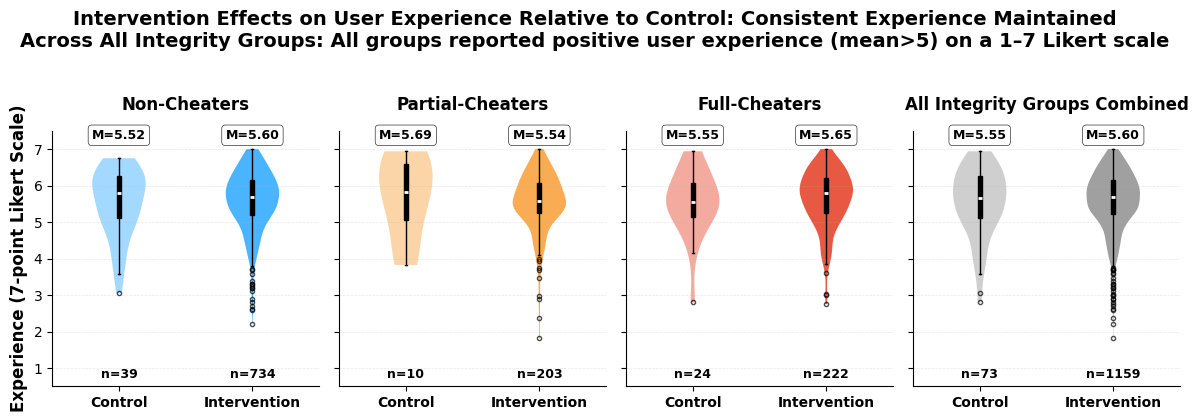


=== Experience Summary by Integrity Group and Condition ===
                                  N Mean Median   SD
Integrity Group  Condition                          
non_cheaters     control         39 5.52   5.81 0.93
                 intervention   734 5.60   5.70 0.80
partial_cheaters control         10 5.69   5.84 1.11
                 intervention   203 5.54   5.59 0.81
full_cheaters    control         24 5.55   5.55 0.90
                 intervention   222 5.65   5.79 0.79
all              control         73 5.55   5.65 0.93
                 intervention  1159 5.60   5.69 0.80

=== Experience Comparison: Control vs Intervention (Welch t-test) ===

NON_CHEATERS
  Welch t-test   : t=0.562, p=0.5773
  Mann-Whitney U : U=14639.500, p=0.8104
  Cohen's d      : 0.098

PARTIAL_CHEATERS
  Welch t-test   : t=-0.403, p=0.6957
  Mann-Whitney U : U=872.000, p=0.4539
  Cohen's d      : -0.147

FULL_CHEATERS
  Welch t-test   : t=0.522, p=0.6057
  Mann-Whitney U : U=2854.500, p=0.5661
  Cohen'

In [81]:
# =============================================================================
# RQ2b plots: Experience by Integrity Group and Condition
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)
integrity_groups_all = ['non_cheaters', 'partial_cheaters', 'full_cheaters', 'all']
titles = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters', 'All Integrity Groups Combined']

integrity_colors = {
    'non_cheaters': '#4bb4ff', 
    'partial_cheaters': '#f9ac53',
    'full_cheaters': '#e85943', 
    'all': '#a0a0a0' 
}

condition_colors = {
    'control': '#d3d3d3',
    'intervention': '#4bb4ff'
}

for idx, (ax, group, title) in enumerate(zip(axes, integrity_groups_all, titles)):

    if group == 'all':
        plot_data = df_combined  
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]
    
    control_data = plot_data[plot_data['condition']=='control']['experience'].dropna()
    intervention_data = plot_data[plot_data['condition']=='intervention']['experience'].dropna()
    
    # Violin plot
    parts = ax.violinplot([control_data, intervention_data], positions=[0, 1], widths=0.4,
                 showmeans=False, showmedians=False, showextrema=False)
    
    # Box plot inside each violin
    ax.boxplot([control_data, intervention_data], positions=[0, 1], widths=0.03,
               patch_artist=True,
               boxprops=dict(facecolor='black', color='black'),
               medianprops=dict(color='white', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1),
               capprops=dict(color='black', linewidth=1),
               showfliers=True,
               flierprops=dict(marker='o', markersize=3, 
                           markeredgecolor='black', alpha=0.7))
    
    # Color violins
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(integrity_colors[group])
        pc.set_alpha(0.5 if i == 0 else 1.0)  
        pc.set_linewidth(1)
    
    # Annotate n and mean
    for pos, condition_data in enumerate([control_data, intervention_data]):
        ax.text(pos, 1, f'n={len(condition_data)}', ha='center', va='top', fontsize=9, fontweight='bold')
        ax.text(pos, 7.2, f'M={condition_data.mean():.2f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', linewidth=0.5, alpha=0.8))
    
    # Styling
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Control', 'Intervention'], fontsize=10, fontweight='bold')
    ax.set_ylim(0.5, 7.5)
    if idx==0: 
        ax.set_ylabel('Experience (7-point Likert Scale)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle(
    "Intervention Effects on User Experience Relative to Control: Consistent Experience Maintained\n"
    "Across All Integrity Groups: All groups reported positive user experience (mean>5) on a 1–7 Likert scale",
    fontsize=14, fontweight='bold', y=0.93
)


plt.tight_layout(rect=[0, 0.1, 1, 0.90])
plt.show()


# =============================================================================
# Print statistics and significance tests
# =============================================================================

# === (1) Experience Summary by Integrity Group and Condition ===

print("\n=== Experience Summary by Integrity Group and Condition ===")

summary_rows = []
for group in integrity_groups_all:
    if group == 'all':
        plot_data = df_combined
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

    for condition in ['control', 'intervention']:
        condition_data = plot_data[plot_data['condition'] == condition]['experience'].dropna()
        n = len(condition_data)
        mean = condition_data.mean()
        median = condition_data.median()
        std = condition_data.std()
        summary_rows.append({
            'Integrity Group': group,
            'Condition': condition,
            'N': n,
            'Mean': mean,
            'Median': median,
            'SD': std
        })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index(['Integrity Group', 'Condition'])
print(summary_df.to_string(formatters={
    'Mean': '{:.2f}'.format,
    'Median': '{:.2f}'.format,
    'SD': '{:.2f}'.format
}))

# === (2) Experience Comparison: Control vs Intervention (Welch t-test) ===

print("\n=== Experience Comparison: Control vs Intervention (Welch t-test) ===")

for group in integrity_groups_all:
    if group == 'all':
        plot_data = df_combined
    else:
        plot_data = df_all[df_all['integrity_group'] == group]
    plot_data = plot_data[plot_data['condition'].isin(['control', 'intervention'])]

    control_data = plot_data[plot_data['condition'] == 'control']['experience'].dropna()
    intervention_data = plot_data[plot_data['condition'] == 'intervention']['experience'].dropna()

    # Welch's t-test (unequal variances)
    t_stat, p_val = ttest_ind(intervention_data, control_data, equal_var=False)

    # Mann–Whitney U test (non-parametric)
    u_stat, p_mw = mannwhitneyu(intervention_data, control_data, alternative='two-sided')

    # Cohen's d
    pooled_sd = np.sqrt(((control_data.std() ** 2) + (intervention_data.std() ** 2)) / 2)
    d = (intervention_data.mean() - control_data.mean()) / pooled_sd

    print(f"\n{group.upper()}")
    print(f"  Welch t-test   : t={t_stat:.3f}, p={p_val:.4f}")
    print(f"  Mann-Whitney U : U={u_stat:.3f}, p={p_mw:.4f}")
    print(f"  Cohen's d      : {d:.3f}")

#### RQ3: How do concept-based interventions influence cheating behavior, performance, and experience across different integrity groups? - EXPLORATORY

##### Cheating, performance, and experience may be interrelated. Cheating can boost performance, which in turn may enhance experience by increasing perceived rewards. To better understand these relationships, we first examine how performance and experience are associated across different integrity groups.

In [67]:
# =============================================================================
# RQ3.1: Performance-Experience Correlations across Integrity Groups (Intervention Only)
# =============================================================================

print("\n" + "="*80)
print("RQ3.1: PERFORMANCE-EXPERIENCE CORRELATIONS ACROSS INTEGRITY GROUPS (INTERVENTION ONLY)")
print("="*80)

from scipy.stats import pearsonr
import pandas as pd

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

correlation_summary = []

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    # --- Performance–Experience correlation ---
    perf_exp = group_data[['performance', 'experience']].dropna()
    if len(perf_exp) > 2:
        r_perf, p_perf = pearsonr(perf_exp['performance'], perf_exp['experience'])
    else:
        r_perf, p_perf = (np.nan, np.nan)
    
    # --- Perceived Ability–Experience correlation ---
    pa_exp = group_data[['perceived_ability', 'experience']].dropna()
    if len(pa_exp) > 2:
        r_pa, p_pa = pearsonr(pa_exp['perceived_ability'], pa_exp['experience'])
    else:
        r_pa, p_pa = (np.nan, np.nan)
    
    correlation_summary.append({
        'Integrity Group': group.replace('_', '-').title(),
        'n (Perf–Exp)': len(perf_exp),
        'r (Perf–Exp)': f"{r_perf:.3f}",
        'p (Perf–Exp)': f"{p_perf:.4f}",
        'Sig (Perf–Exp)': '***' if p_perf < 0.001 else '**' if p_perf < 0.01 else '*' if p_perf < 0.05 else 'ns',
        'n (PA–Exp)': len(pa_exp),
        'r (PA–Exp)': f"{r_pa:.3f}",
        'p (PA–Exp)': f"{p_pa:.4f}",
        'Sig (PA–Exp)': '***' if p_pa < 0.001 else '**' if p_pa < 0.01 else '*' if p_pa < 0.05 else 'ns'
    })

corr_df = pd.DataFrame(correlation_summary)
print("\n" + corr_df.to_string(index=False))
print("="*90)


print(f"\nImportant findings")
  
print(f"    Non-cheaters: significant but weak positive correlations between performance and experience (r=0.12, p=0.002)")
print(f"    Full-cheaters: significant and small to moderate positive correlations between performance and experience (r=0.22, p=0.001)")
print(f"    Partial-cheaters: no significant correlation between performance and experience")
print(f"    Perceived ability was found to be weakly (positive) correlated with experience only among non-cheaters (r=0.09, p=0.01)")


RQ3.1: PERFORMANCE-EXPERIENCE CORRELATIONS ACROSS INTEGRITY GROUPS (INTERVENTION ONLY)

 Integrity Group  n (Perf–Exp) r (Perf–Exp) p (Perf–Exp) Sig (Perf–Exp)  n (PA–Exp) r (PA–Exp) p (PA–Exp) Sig (PA–Exp)
    Non-Cheaters           734        0.115       0.0018             **         734      0.090     0.0149            *
Partial-Cheaters           203        0.006       0.9285             ns         203     -0.078     0.2661           ns
   Full-Cheaters           222        0.222       0.0009            ***         222      0.125     0.0624           ns

Important findings
    Non-cheaters: significant but weak positive correlations between performance and experience (r=0.12, p=0.002)
    Full-cheaters: significant and small to moderate positive correlations between performance and experience (r=0.22, p=0.001)
    Partial-cheaters: no significant correlation between performance and experience
    Perceived ability was found to be weakly (positive) correlated with experience only a

##### Next, to explore whether the effectiveness of concept-based interventions on cheating behavior, performance, and experience varies among different integrity groups, We have two options: 1) concepts to performance and experience for each integrity group; 2) concept to mechanism; and then mechanisms to performance and experience for each integrity group.
##### Option 1 gives unreliable results due to small sample sizes in some groups (e.g., full-cheaters and partial cheaters in all concept groups < 20 participants. Therefore, we proceed with option 2, where all mechanisms have sufficient sample sizes within each integrity group because every participant had rated all mechanisms.

In [125]:
# =============================================================================
# RQ3.2: Mechanism Moderation of Performance–Experience RELATIONSHIP (Regression-Based)
# =============================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

print("\n" + "="*80)
print("RQ3.2: MECHANISM MODERATION OF PERFORMANCE–EXPERIENCE RELATIONSHIP (REGRESSION-BASED)")
print("="*80)

def test_moderation(df, mechanism, group):
    """Tests if a mechanism moderates the performance–experience relationship."""
    data = df[df['integrity_group'] == group].copy()
    sub = data[[mechanism, 'performance', 'experience']].dropna()
    if len(sub) < 50:
        return None

    # Standardize variables
    for var in ['performance', mechanism]:
        sub[f'{var}_std'] = (sub[var] - sub[var].mean()) / sub[var].std()

    sub['interaction'] = sub['performance_std'] * sub[f'{mechanism}_std']

    X = sm.add_constant(sub[['performance_std', f'{mechanism}_std', 'interaction']])
    y = sub['experience']

    model = sm.OLS(y, X).fit()

    # Extract interaction term and significance
    p = model.pvalues['interaction']
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'

    return {
        'Integrity_Group': group.replace('_', '-').title(),
        'Mechanism': mechanism,
        'β_perf': model.params['performance_std'],
        'β_mech': model.params[f'{mechanism}_std'],
        'β_interaction': model.params['interaction'],
        'p_interaction': p,
        'Sig': sig,
        'R²': model.rsquared
    }

available_mechs = [m for m in mechanisms if m in df_int.columns]

# Run moderation tests
results = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    for mech in available_mechs:
        res = test_moderation(df_int, mech, group)
        if res: results.append(res)

moderation_df = pd.DataFrame(results)

# Sort by significance and display
sig_df = moderation_df.query('p_interaction < 0.05').sort_values('p_interaction')

print("\nFull results:")
print(moderation_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

print("\n" + "="*80)
print("SIGNIFICANT MODERATION EFFECTS (p < 0.05)")
print("="*80)
print(sig_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
print("="*80)




RQ3.2: MECHANISM MODERATION OF PERFORMANCE–EXPERIENCE RELATIONSHIP (REGRESSION-BASED)

Full results:
 Integrity_Group                      Mechanism  β_perf  β_mech  β_interaction  p_interaction Sig    R²
    Non-Cheaters     autonomy_need_satisfaction   0.065   0.247         -0.025          0.358  ns 0.111
    Non-Cheaters      autonomy_need_frustration   0.073  -0.123          0.010          0.714  ns 0.038
    Non-Cheaters   competence_need_satisfaction   0.019   0.315          0.019          0.511  ns 0.152
    Non-Cheaters    competence_need_frustration   0.034  -0.175          0.013          0.671  ns 0.057
    Non-Cheaters  relatedness_need_satisfaction   0.137   0.280         -0.026          0.354  ns 0.136
    Non-Cheaters   relatedness_need_frustration   0.086  -0.257          0.047          0.103  ns 0.122
    Non-Cheaters           cognitive_discomfort  -0.002  -0.397         -0.025          0.342  ns 0.231
    Non-Cheaters            moral_disengagement   0.101  -0.033   

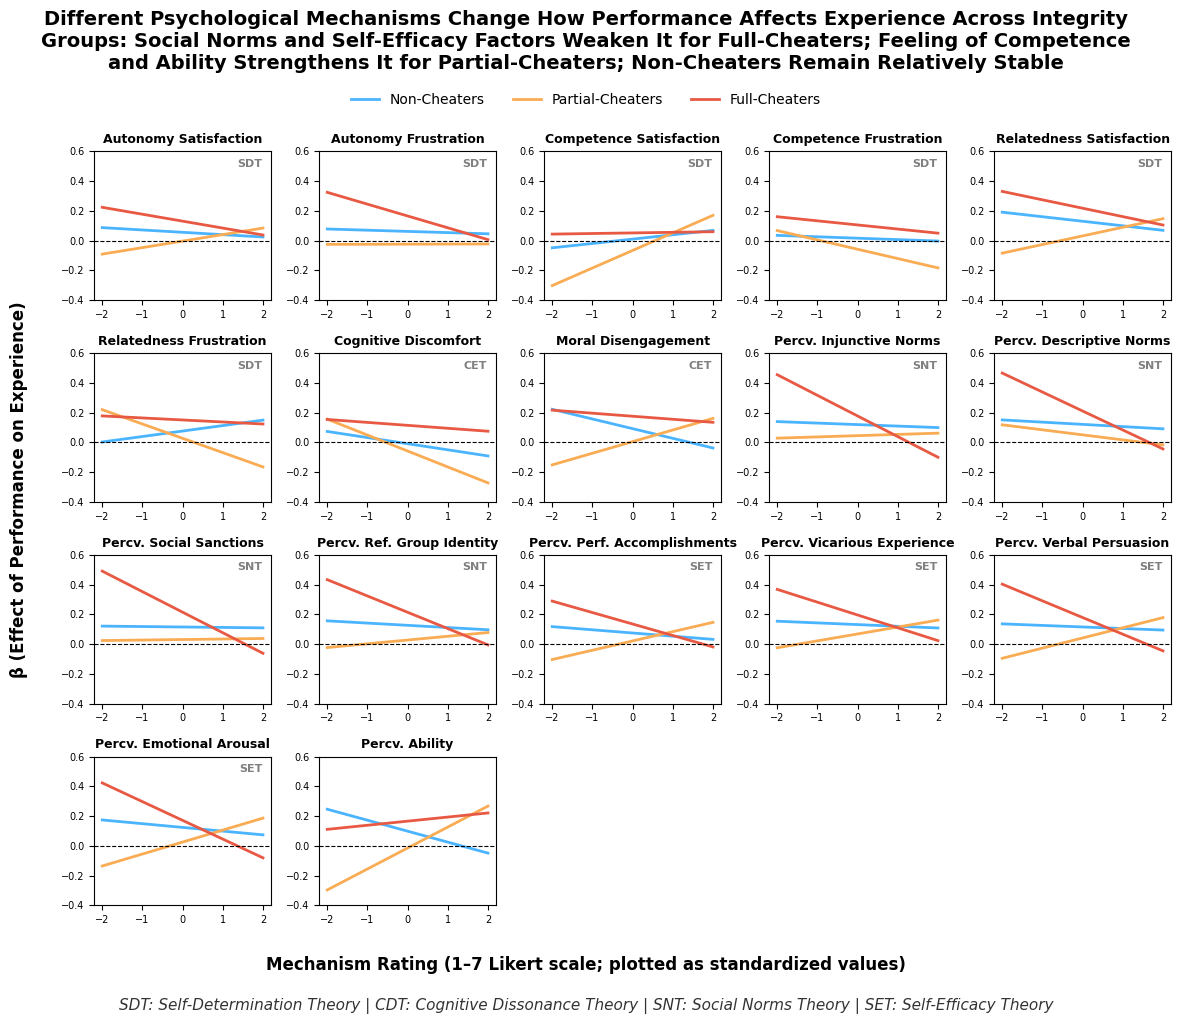

In [ ]:
#==============================================================================
# RQ3.2: Visualization of Moderation Effects of Mechanisms on 
# Performance–Experience Relationship
#==============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Prepare mechanism display names
mechanisms = list(mechanism_display_names.keys())
display_labels = [mechanism_display_names[m] for m in mechanisms]

# Prepare slope data
groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
colors = {'Non-Cheaters':'#4bb4ff', 'Partial-Cheaters':'#f9ac53', 'Full-Cheaters':'#e85943'}

# Compute simple slopes
slopes_high = []
slopes_low = []

# for mechanism in mechanisms:
#     slopes_h = []
#     slopes_l = []
#     for group in groups:
#         row = moderation_df[(moderation_df['Integrity_Group']==group) & 
#                             (moderation_df['Mechanism']==mechanism)]
#         if len(row)==0:
#             slopes_h.append(np.nan)
#             slopes_l.append(np.nan)
#             continue
#         b_perf = row['β_perf'].values[0]
#         b_int  = row['β_interaction'].values[0]
#         slopes_h.append(b_perf + b_int*1)   # +1 SD mechanism
#         slopes_l.append(b_perf + b_int*-1)  # -1 SD mechanism
#     slopes_high.append(slopes_h)
#     slopes_low.append(slopes_l)

# slopes_high = np.array(slopes_high)
# slopes_low  = np.array(slopes_low)

M_range = np.linspace(-2, 2, 100)  # mechanism values in SD units

# Plot slope plots
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

for i, mechanism in enumerate(mechanisms):
    ax = axes[i]
    for group in groups:
        row = moderation_df[(moderation_df['Integrity_Group']==group) & 
                            (moderation_df['Mechanism']==mechanism)]
        if len(row)==0:
            continue
        b_perf = row['β_perf'].values[0]
        b_int  = row['β_interaction'].values[0]
        slope_perf = b_perf + b_int * M_range
        ax.plot(M_range, slope_perf, color=colors[group], linewidth=2, label=group)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(mechanism_display_names[mechanism], fontsize=9, fontweight='bold')
    ax.set_ylim(-0.4, 0.6)
    ax.tick_params(labelsize=7)
    
    # Add theory label if mechanism is not Perceived Ability
    theory = mechanism_theory.get(mechanism, None)
    if theory is not None and mechanism != 'perceived_ability':
        ax.text(0.95, 0.95, theory, transform=ax.transAxes, fontsize=8,
                fontweight='bold', ha='right', va='top', color='gray')

# Hide empty axes if any
for ax in axes[len(mechanisms):]:
    ax.axis('off')

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors['Non-Cheaters'], linewidth=2, label='Non-Cheaters'),
    Line2D([0], [0], color=colors['Partial-Cheaters'], linewidth=2, label='Partial-Cheaters'),
    Line2D([0], [0], color=colors['Full-Cheaters'], linewidth=2, label='Full-Cheaters'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, 
           bbox_to_anchor=(0.5, 0.91), frameon=False, fontsize=10)

# Suptitle
fig.suptitle(
    'Different Psychological Mechanisms Change How Performance Affects Experience Across Integrity\n'
    'Groups: Social Norms and Self-Efficacy Factors Weaken It for Full-Cheaters; Feeling of Competence\n'
    'and Ability Strengthens It for Partial-Cheaters; Non-Cheaters Remain Relatively Stable',
    fontsize=14, fontweight='bold', y=0.98
)

fig.text(0.5, -0.02,
            "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
            "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
            ha='center', fontsize=11, style='italic', color='black', alpha=0.8)


# Common x and y labels outside the subplots
fig.text(0.5, 0.02, 'Mechanism Rating (1–7 Likert scale; plotted as standardized values)', ha='center', fontsize=12, fontweight='bold')
fig.text(0.02, 0.5, 'β (Effect of Performance on Experience)', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0.05,0.05,1,0.95])
plt.show()


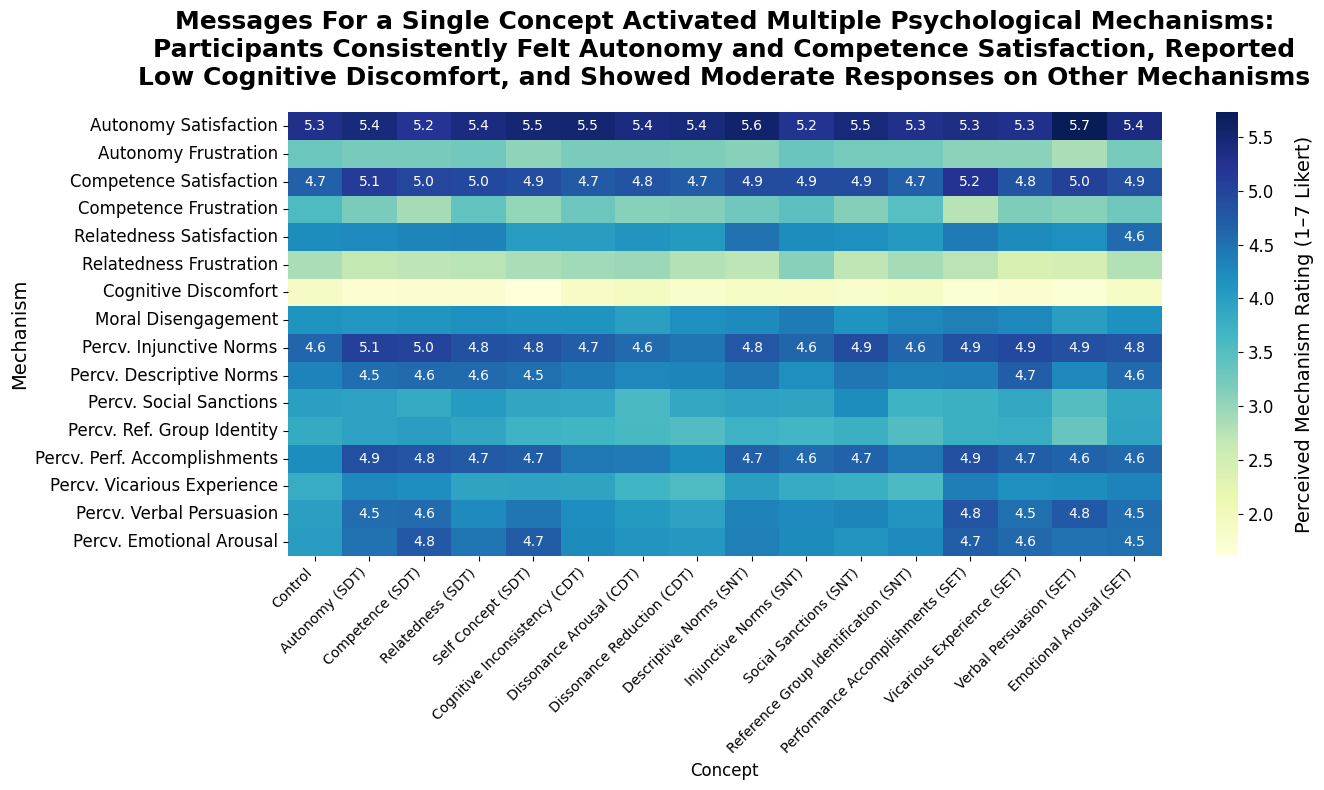

In [ ]:
#=============================================================================
# RQ3.3: Explore Concept-Mechanism Relationships (Heatmap)
#=============================================================================

import pandas as pd
import numpy as np

df_int = df[df['concept'].notna()].copy()

all_results = []
# Omit perceived_ability
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']

for mech in mechanisms:
    
    # Calculate mean for each concept
    concept_means = df_int.groupby('concept')[mech].agg(['mean', 'std', 'count']).reset_index()
    concept_means.columns = ['Concept', 'Mean', 'Std', 'N']
    
    # Sort by mean (descending)
    concept_means = concept_means.sort_values('Mean', ascending=False)
    
    # Format for display
    concept_means['Mean'] = concept_means['Mean'].round(3)
    concept_means['Std'] = concept_means['Std'].round(3)
    
    # Store for summary
    for _, row in concept_means.iterrows():
        all_results.append({
            'mechanism': mech,
            'concept': row['Concept'],
            'mean': row['Mean'],
            'std': row['Std'],
            'n': row['N']
        })


summary_df = pd.DataFrame(all_results)
concept_order_filtered = [c for c in concept_order if c != 'intervention']
heatmap_data = summary_df.pivot(index='mechanism', columns='concept', values='mean')

heatmap_data = heatmap_data.reindex(index=mechanisms_filtered, columns=concept_order_filtered)

heatmap_data.index = heatmap_data.index.map(mechanism_display_names)
heatmap_data.columns = heatmap_data.columns.map(concept_display_names)

plt.figure(figsize=(14, 8))

# Create annot array: show value only if >=4.5 (atleast agree to concept-mechanism link)
annot_array = heatmap_data.applymap(lambda x: f"{x:.1f}" if x >= 4.5 else "")

# Plot heatmap
ax = sns.heatmap(
    heatmap_data,
    annot=annot_array,
    fmt="", 
    cmap="YlGnBu",
    cbar_kws={'label': 'Perceived Mechanism Rating (1–7 Likert)'}
)



cbar = ax.collections[0].colorbar
cbar.set_label('Perceived Mechanism Rating (1–7 Likert)', fontsize=14, labelpad=15)
cbar.ax.tick_params(labelsize=12)

plt.title('Messages For a Single Concept Activated Multiple Psychological Mechanisms:\n'
          'Participants Consistently Felt Autonomy and Competence Satisfaction, Reported\n'
          'Low Cognitive Discomfort, and Showed Moderate Responses on Other Mechanisms', 
          fontsize=18, fontweight='bold', pad=20)

plt.ylabel("Mechanism", fontsize=14)
plt.xlabel("Concept", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

Saved mechanism_activation_non_cheaters.csv
Saved mechanism_activation_partial_cheaters.csv
Saved mechanism_activation_full_cheaters.csv


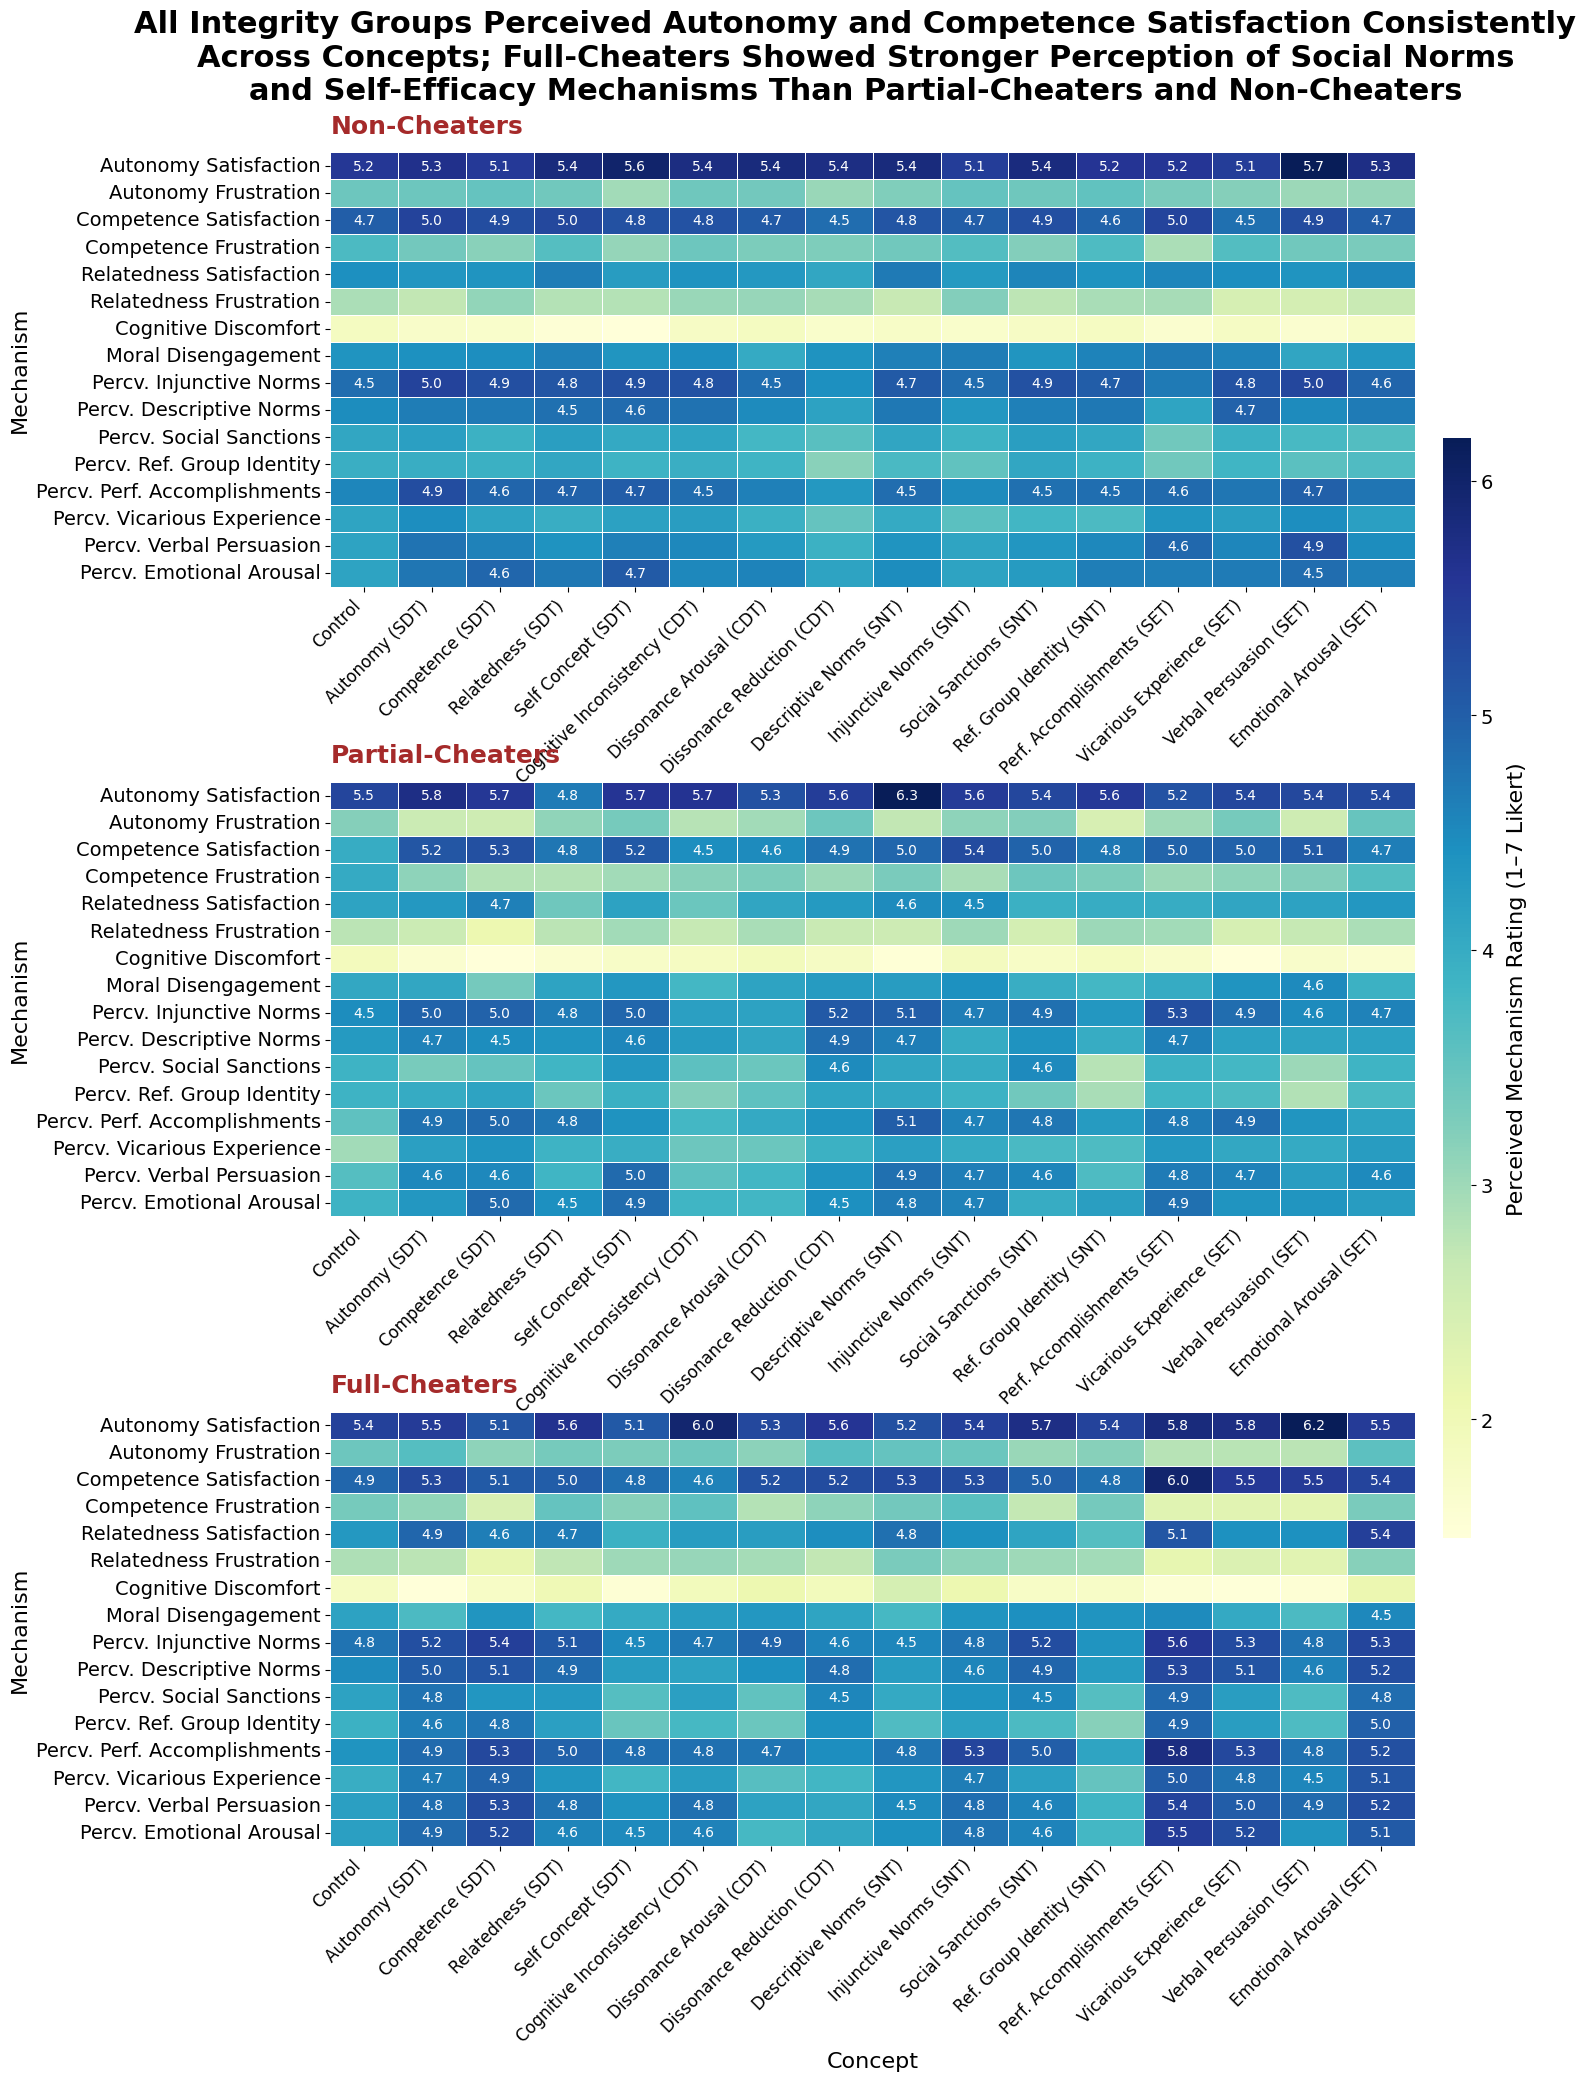

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#=============================================================================
# RQ3.3: Mechanism Activation by Concepts (Separate Heatmaps per Integrity Group)
#=============================================================================

df_int = df[df['concept'].notna()].copy()

# Short labels for subplot titles
integrity_groups = {
    'non_cheaters': 'Non-Cheaters',
    'partial_cheaters': 'Partial-Cheaters',
    'full_cheaters': 'Full-Cheaters',
}

# Filter out the "intervention" concept
concept_order_filtered = [c for c in concept_order if c != 'intervention']

# Omit perceived_ability from mechanisms
mechanisms_filtered = [m for m in mechanisms if m != 'perceived_ability']

# Create a 3x1 grid
fig, axes = plt.subplots(3, 1, figsize=(14, 22), constrained_layout=False)

# Adjust spacing so suptitle doesn't overlap
fig.subplots_adjust(top=0.88, hspace=0.45)

# Reserve a single colorbar axis (fixed position) to align all heatmaps
# This ensures consistent right margin width across subplots
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]

for i, (group_key, group_label) in enumerate(integrity_groups.items()):
    ax = axes[i]
    df_group = df_int[df_int['integrity_group'] == group_key].copy()

    # Compute summary stats
    all_results = []
    for mech in mechanisms_filtered:
        concept_means = (
            df_group.groupby('concept')[mech]
            .agg(['mean', 'std', 'count'])
            .reset_index()
        )
        concept_means.columns = ['Concept', 'Mean', 'Std', 'N']
        for _, row in concept_means.iterrows():
            all_results.append({
                'mechanism': mech,
                'concept': row['Concept'],
                'mean': row['Mean'],
                'std': row['Std'],
                'n': row['N']
            })

    summary_df = pd.DataFrame(all_results)
    csv_filename = f"mechanism_activation_{group_key}.csv"
    summary_df.to_csv(csv_filename, index=False)
    print(f"Saved {csv_filename}")

    # Pivot for heatmap
    heatmap_data = summary_df.pivot(index='mechanism', columns='concept', values='mean')
    heatmap_data = heatmap_data.reindex(index=mechanisms_filtered, columns=concept_order_filtered)

    # Apply display names
    heatmap_data.index = heatmap_data.index.map(mechanism_display_names)
    heatmap_data.columns = heatmap_data.columns.map(concept_display_names)

    # Annotate only high values
    annot_array = heatmap_data.applymap(lambda x: f"{x:.1f}" if pd.notna(x) and x >= 4.5 else "")

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        annot=annot_array,
        fmt="",
        cmap="YlGnBu",
        ax=ax,
        cbar=(i == 2),               # Only show the actual colorbar on the last plot
        cbar_ax=(cbar_ax if i == 2 else None),  # Fix colorbar position for the last plot
        linewidths=0.5, linecolor="white"
    )

    # If it's the last plot, format the colorbar
    if i == 2:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Perceived Mechanism Rating (1–7 Likert)', fontsize=16, labelpad=10)
        cbar.ax.tick_params(labelsize=14)

    # Keep identical width by reserving cbar space (even for upper plots)
    if i < 2:
        # Add an invisible placeholder colorbar (white patch) to match layout
        ax.figure.add_axes([0.92, ax.get_position().y0, 0.02, ax.get_position().height]).set_visible(False)

    # Proper tick positioning
    n_cols = heatmap_data.shape[1]
    n_rows = heatmap_data.shape[0]
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=12)
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=14)

    # Titles and axis labels
    ax.set_title(group_label, fontsize=18, fontweight='bold', pad=14, loc='left', color='brown')
    ax.set_ylabel("Mechanism", fontsize=16)
    ax.set_xlabel("Concept", fontsize=16)

# Add a shared suptitle with spacing
fig.suptitle(
    'All Integrity Groups Perceived Autonomy and Competence Satisfaction Consistently\n'
    'Across Concepts; Full-Cheaters Showed Stronger Perception of Social Norms\n'
    'and Self-Efficacy Mechanisms Than Partial-Cheaters and Non-Cheaters',
    fontsize=22, fontweight='bold', y=0.945
)

plt.show()



MECHANISM MODERATION OF PERCEIVED PERFORMANCE-PERCEIVED EXPERIENCE RELATIONSHIP

Full results:
 Integrity_Group                      Mechanism  β_perf  β_mech  β_interaction  p_interaction Sig    R²
    Non-Cheaters     autonomy_need_satisfaction   0.959   0.059          0.026          0.482  ns 0.454
    Non-Cheaters      autonomy_need_frustration   0.971  -0.006         -0.010          0.789  ns 0.452
    Non-Cheaters   competence_need_satisfaction   0.909   0.166          0.049          0.163  ns 0.464
    Non-Cheaters    competence_need_frustration   0.961  -0.127         -0.011          0.776  ns 0.460
    Non-Cheaters  relatedness_need_satisfaction   0.904   0.130          0.072          0.041   * 0.463
    Non-Cheaters   relatedness_need_frustration   0.934  -0.138         -0.022          0.544  ns 0.461
    Non-Cheaters           cognitive_discomfort   0.952  -0.114          0.005          0.903  ns 0.458
    Non-Cheaters            moral_disengagement   0.966  -0.098         

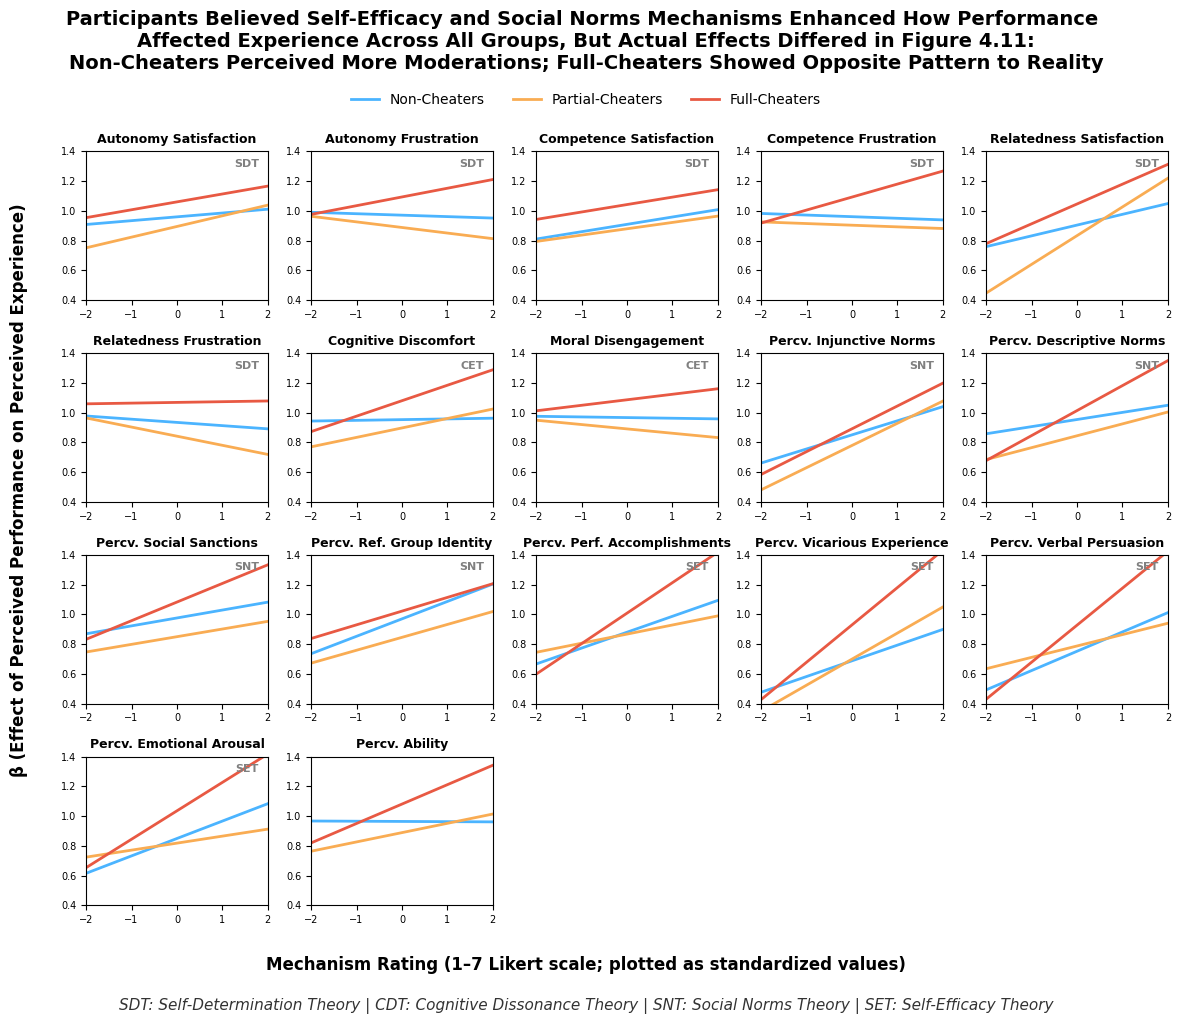

In [135]:
# =============================================================================
# Mechanism Moderation of Perceived Performance–Perceived Experience 
# Relationship (Regression-Based)
# =============================================================================

import statsmodels.api as sm

def test_moderation_perceived(df, mechanism, group):
    """Tests if a mechanism moderates the perceived performance–perceived experience relationship."""
    data = df[df['integrity_group'] == group].copy()
    sub = data[[mechanism, 'perceived_performance', 'perceived_experience']].dropna()
    if len(sub) < 50:
        return None

    # Standardize variables
    for var in ['perceived_performance', mechanism]:
        sub[f'{var}_std'] = (sub[var] - sub[var].mean()) / sub[var].std()

    sub['interaction'] = sub['perceived_performance_std'] * sub[f'{mechanism}_std']

    X = sm.add_constant(sub[['perceived_performance_std', f'{mechanism}_std', 'interaction']])
    y = sub['perceived_experience']

    model = sm.OLS(y, X).fit()

    p = model.pvalues['interaction']
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'

    return {
        'Integrity_Group': group.replace('_', '-').title(),
        'Mechanism': mechanism,
        'β_perf': model.params['perceived_performance_std'],
        'β_mech': model.params[f'{mechanism}_std'],
        'β_interaction': model.params['interaction'],
        'p_interaction': p,
        'Sig': sig,
        'R²': model.rsquared
    }

# Run moderation tests (include perceived_ability)
results_perceived = []
for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    for mech in mechanisms:  # Use 'mechanisms' instead of 'available_mechs' to include perceived_ability
        res = test_moderation_perceived(df_int, mech, group)
        if res: results_perceived.append(res)

moderation_df_perceived = pd.DataFrame(results_perceived)

# Print the moderation results
print("\n" + "="*80)
print("MECHANISM MODERATION OF PERCEIVED PERFORMANCE-PERCEIVED EXPERIENCE RELATIONSHIP")
print("="*80)
print("\nFull results:")
print(moderation_df_perceived.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

# Print significant effects
sig_df_perceived = moderation_df_perceived.query('p_interaction < 0.05').sort_values('p_interaction')
print("\n" + "="*80)
print("SIGNIFICANT MODERATION EFFECTS (p < 0.05)")
print("="*80)
print(sig_df_perceived.to_string(index=False, float_format=lambda x: f"{x:.3f}"))
print("="*80)


# =============================================================================
# Visualization of Moderation Effects (Perceived Performance-Experience)
# =============================================================================

M_range = np.linspace(-2, 2, 100)

# Define colors and groups as dictionaries
groups = ['Non-Cheaters', 'Partial-Cheaters', 'Full-Cheaters']
colors = {'Non-Cheaters':'#4bb4ff', 'Partial-Cheaters':'#f9ac53', 'Full-Cheaters':'#e85943'}

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
axes = axes.flatten()

for i, mechanism in enumerate(mechanisms):
    ax = axes[i]
    for group in groups:
        row = moderation_df_perceived[(moderation_df_perceived['Integrity_Group']==group) & 
                                      (moderation_df_perceived['Mechanism']==mechanism)]
        if len(row)==0:
            continue
        b_perf = row['β_perf'].values[0]
        b_int  = row['β_interaction'].values[0]
        slope_perf = b_perf + b_int * M_range
        ax.plot(M_range, slope_perf, color=colors[group], linewidth=2, label=group)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(mechanism_display_names[mechanism], fontsize=9, fontweight='bold')
    ax.set_ylim(0.4, 1.4)  # Adjusted for perceived performance-experience range
    ax.set_xlim(-2, 2)
    ax.tick_params(labelsize=7)
    
    theory = mechanism_theory.get(mechanism, None)
    if theory is not None and mechanism != 'perceived_ability':
        ax.text(0.95, 0.95, theory, transform=ax.transAxes, fontsize=8,
                fontweight='bold', ha='right', va='top', color='gray')

for ax in axes[len(mechanisms):]:
    ax.axis('off')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors['Non-Cheaters'], linewidth=2, label='Non-Cheaters'),
    Line2D([0], [0], color=colors['Partial-Cheaters'], linewidth=2, label='Partial-Cheaters'),
    Line2D([0], [0], color=colors['Full-Cheaters'], linewidth=2, label='Full-Cheaters'),
]
fig.legend(handles=legend_elements, loc='upper center', ncol=5, 
           bbox_to_anchor=(0.5, 0.91), frameon=False, fontsize=10)

fig.suptitle(
    'Participants Believed Self-Efficacy and Social Norms Mechanisms Enhanced How Performance \n'
    'Affected Experience Across All Groups, But Actual Effects Differed in Figure 4.11:\n'
    'Non-Cheaters Perceived More Moderations; Full-Cheaters Showed Opposite Pattern to Reality',
    fontsize=14, fontweight='bold', y=0.98
)

fig.text(0.5, -0.02,
         "SDT: Self-Determination Theory | CDT: Cognitive Dissonance Theory | "
         "SNT: Social Norms Theory | SET: Self-Efficacy Theory",
         ha='center', fontsize=11, style='italic', color='black', alpha=0.8)

fig.text(0.5, 0.02, 'Mechanism Rating (1–7 Likert scale; plotted as standardized values)', 
         ha='center', fontsize=12, fontweight='bold')
fig.text(0.02, 0.5, 'β (Effect of Perceived Performance on Perceived Experience)', 
         va='center', rotation='vertical', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0.05,0.05,1,0.95])
plt.show()

In [136]:
# =============================================================================
# Perceived Performance-Experience Correlations (Intervention Only)
# =============================================================================

from scipy.stats import pearsonr

df_int = df_combined[df_combined['condition'] == 'intervention'].copy()

correlation_summary = []

for group in ['non_cheaters', 'partial_cheaters', 'full_cheaters']:
    group_data = df_int[df_int['integrity_group'] == group]
    
    # Perceived Performance–Perceived Experience correlation
    perf_exp = group_data[['perceived_performance', 'perceived_experience']].dropna()
    r_perf, p_perf = pearsonr(perf_exp['perceived_performance'], perf_exp['perceived_experience']) if len(perf_exp) > 2 else (np.nan, np.nan)
    
    # Perceived Ability–Perceived Experience correlation
    pa_exp = group_data[['perceived_ability', 'perceived_experience']].dropna()
    r_pa, p_pa = pearsonr(pa_exp['perceived_ability'], pa_exp['perceived_experience']) if len(pa_exp) > 2 else (np.nan, np.nan)
    
    correlation_summary.append({
        'Integrity Group': group.replace('_', '-').title(),
        'n (Perf–Exp)': len(perf_exp),
        'r (Perf–Exp)': f"{r_perf:.3f}",
        'p (Perf–Exp)': f"{p_perf:.4f}",
        'Sig (Perf–Exp)': '***' if p_perf < 0.001 else '**' if p_perf < 0.01 else '*' if p_perf < 0.05 else 'ns',
        'n (PA–Exp)': len(pa_exp),
        'r (PA–Exp)': f"{r_pa:.3f}",
        'p (PA–Exp)': f"{p_pa:.4f}",
        'Sig (PA–Exp)': '***' if p_pa < 0.001 else '**' if p_pa < 0.01 else '*' if p_pa < 0.05 else 'ns'
    })

print("\n" + pd.DataFrame(correlation_summary).to_string(index=False))

print(f"\nImportant findings")

print(f"    All integrity groups: significant but strong positive correlations between perceived performance and perceived experience (r>0.67, p<.001)")
print(f"    Perceived ability was found to be weakly (positive) correlated with perceived experience only among non- and full-cheaters (r<0.15, p<.05)")


 Integrity Group  n (Perf–Exp) r (Perf–Exp) p (Perf–Exp) Sig (Perf–Exp)  n (PA–Exp) r (PA–Exp) p (PA–Exp) Sig (PA–Exp)
    Non-Cheaters           734        0.672       0.0000            ***         734      0.129     0.0005          ***
Partial-Cheaters           203        0.686       0.0000            ***         203      0.122     0.0825           ns
   Full-Cheaters           222        0.748       0.0000            ***         222      0.133     0.0480            *

Important findings
    All integrity groups: significant but strong positive correlations between perceived performance and perceived experience (r>0.67, p<.001)
    Perceived ability was found to be weakly (positive) correlated with perceived experience only among non- and full-cheaters (r<0.15, p<.05)
